In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

# plot inline
%matplotlib inline

# Part 1: Passive buy and hold returns (For full period)

In [6]:
# global variables

start_date = "2006-11-01"
end_date   = "2025-11-13"  # end is *exclusive*, so this covers up to 2025-11-12
starting_capital = 100_000.0

In [7]:
spy =\
(
    yf.
    download(
        "^GSPC",
        start = start_date,
        end = end_date
    )
)

[*********************100%***********************]  1 of 1 completed


In [8]:
spy

Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000
...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000


In [9]:
(
    spy
    .isna()
    .sum()
)

Price   Ticker
Close   ^GSPC     0
High    ^GSPC     0
Low     ^GSPC     0
Open    ^GSPC     0
Volume  ^GSPC     0
dtype: int64

<Axes: xlabel='Date'>

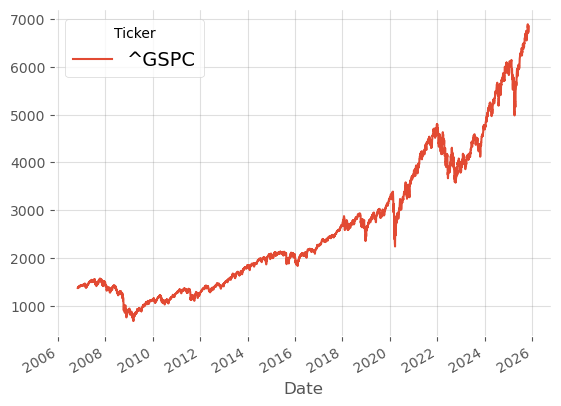

In [10]:
(
    spy['Close']
).plot()

In [11]:
return_df =\
(
    spy
    ['Close']
    .rename(columns={'^GSPC': "Close"})
)

return_df

Ticker,Close
Date,
2006-11-01,1367.810059
2006-11-02,1367.339966
2006-11-03,1364.300049
2006-11-06,1379.780029
2006-11-07,1382.839966
...,...
2025-11-06,6720.319824
2025-11-07,6728.799805
2025-11-10,6832.430176


# Part 2: Machine Learning

In [12]:
# packages for Supervised Learning

# Let's import our built-in algorithms from scipy toolkit for machine learning

# Oldies But Goodies...

from sklearn.linear_model import LinearRegression # Least Squares

from sklearn.svm import SVR # Support Vector Machine

from sklearn.neighbors import KNeighborsRegressor # K-Nearest Neighbors

# Regularization (Penalized Regressors) --> Linear

from sklearn.linear_model import ElasticNet # Elastic Net Penalty
from sklearn.linear_model import Lasso # LASSO

# Decision Tree with Ensemble --> Non-linear

from sklearn.tree import DecisionTreeRegressor # Decision Tree

## Bagging (Bootstrapped-AGGregation) --> intelligent architecture like Homo Sapiens

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

## Boosting (more recent approaches) --> Homo Sapiens Sapiens

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

### Step 2. Feature Engineering (Big 5 + 3)

from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2

from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

import statsmodels.tsa.arima.model as stats
from statsmodels.graphics.tsaplots import plot_acf
from pandas.plotting import scatter_matrix

from sklearn.metrics import mean_squared_error


In [13]:
return_period = 1

In [14]:
return_df.head(5)

Ticker,Close
Date,
2006-11-01,1367.810059
2006-11-02,1367.339966
2006-11-03,1364.300049
2006-11-06,1379.780029
2006-11-07,1382.839966


## Y Variable - 1 day log return

In [15]:
Y =\
(
    np
    .log(return_df['Close']
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name = 'SPY_pred'

Y

Date
2006-11-01   -0.000344
2006-11-02   -0.002226
2006-11-03    0.011283
2006-11-06    0.002215
2006-11-07    0.002081
                ...   
2025-11-06    0.001261
2025-11-07    0.015284
2025-11-10    0.002073
2025-11-11    0.000629
2025-11-12         NaN
Name: SPY_pred, Length: 4788, dtype: float64

# Features

### 1.Lagged returns 1 day to 5 days

In [16]:
lagged_return_periods = [i for i in range(1,6)]

X1 =\
pd.concat(
    [np
    .log(return_df['Close']
        )
    .diff(i) for i in lagged_return_periods
    ],
    axis = 1
).dropna()

X1.columns = [f'{i}DT' for i in lagged_return_periods]

X1

,1DT,2DT,3DT,4DT,5DT
Date,,,,,
2006-11-08,0.002081,0.004296,0.015578,0.013353,0.013009
2006-11-09,-0.005347,-0.003267,-0.001051,0.010231,0.008005
2006-11-10,0.001863,-0.003484,-0.001404,0.000811,0.012094
2006-11-13,0.002546,0.004409,-0.000939,0.001142,0.003357
2006-11-14,0.006336,0.008882,0.010745,0.005398,0.007478
...,...,...,...,...,...
2025-11-06,-0.011241,-0.007594,-0.019400,-0.017681,-0.015067
2025-11-07,0.001261,-0.009980,-0.006333,-0.018139,-0.016420
2025-11-10,0.015284,0.016545,0.005304,0.008950,-0.002856


### 2.Simple moving averages

In [17]:
sma_periods = [21,63,252]

X2 = pd.concat([
    return_df['Close']
    .rolling(i,
             center=False).mean()
    for i in [21, 63, 252]
], axis=1)
X2.columns = [f"SMA{i}" for i in sma_periods]
X2 

,SMA21,SMA63,SMA252
Date,,,
2006-11-01,NaN,NaN,NaN
2006-11-02,NaN,NaN,NaN
2006-11-03,NaN,NaN,NaN
2006-11-06,NaN,NaN,NaN
2006-11-07,NaN,NaN,NaN
...,...,...,...
2025-11-06,6748.100446,6618.598548,6094.837491
2025-11-07,6747.799967,6624.239018,6098.591619
2025-11-10,6761.129511,6630.376643,6102.176500


### 3.Exponential moving averages

In [18]:
ema_periods = [10,30,200]

X3 = pd.concat([
    return_df['Close'].ewm(span=i, adjust=False).mean()
    for i in ema_periods
], axis=1)
X3.columns = [f"EMA{i}" for i in ema_periods]
# X3.dropna(inplace=True)
X3 #ewma

,EMA10,EMA30,EMA200
Date,,,
2006-11-01,1367.810059,1367.810059,1367.810059
2006-11-02,1367.724587,1367.779730,1367.805381
2006-11-03,1367.101944,1367.555234,1367.770502
2006-11-06,1369.407050,1368.343931,1367.890000
2006-11-07,1371.849399,1369.279159,1368.038756
...,...,...,...
2025-11-06,6789.225371,6731.548794,6234.365178
2025-11-07,6778.238905,6731.371440,6239.284926
2025-11-10,6788.091863,6737.891358,6245.186868


### 4.RSI

In [19]:
def compute_rsi_strategy(close_df, window, price_col = 'Close'):
    df = close_df.copy().reset_index();

    df["passive_returns"] =\
    (
        np
        .log(df[price_col]
            /
            df[price_col].shift(1)
            )
    )

    df['gain_or_loss'] =\
    (
        np.sign(
            df['passive_returns']
        )
    )

    df['gain'] =\
    (
        np.where(
            df['gain_or_loss'] == 1,
            df['passive_returns'],
            0
        )
    )

    df['loss'] =\
    (
        np.where(
            df['gain_or_loss'] == -1,
            -df['passive_returns'],
            0
        )
    )

    df['avg_gain'] =\
    (
        df['gain']
        .rolling(window=window)
        .mean()
    )

    df['avg_loss'] =\
    (
        df['loss']
        .rolling(window=window)
        .mean()
    )

    df['RSI'] =\
    (
        100
        - (100 
        / 
        (1 
            + 
            (df['avg_gain']/ df['avg_loss'])
            )
        )
    )
    df = df.set_index('Date')
    return df

In [20]:
rsi_periods = [10,30,200]

X4 = pd.concat([
    compute_rsi_strategy(
        return_df['Close'],
        window=i,
        price_col='Close'
    )['RSI']
    for i in rsi_periods
], axis=1)
X4.columns = [f"RSI{i}" for i in rsi_periods]
X4

,RSI10,RSI30,RSI200
Date,,,
2006-11-01,NaN,NaN,NaN
2006-11-02,NaN,NaN,NaN
2006-11-03,NaN,NaN,NaN
2006-11-06,NaN,NaN,NaN
2006-11-07,NaN,NaN,NaN
...,...,...,...
2025-11-06,47.876348,54.873023,53.254200
2025-11-07,41.808905,53.669848,53.129871
2025-11-10,44.792050,56.820149,53.697066


### Stochastic Oscillator 

In [21]:
def STOK(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    return STOK

def STOD(close, low, high, n):
    STOK = ((close - low.rolling(n).min()) / \
            (high.rolling(n).max() - low.rolling(n).min()
            )
           ) * 100
    
    STOD = STOK.rolling(3).mean()
    return STOD

In [22]:
stok_periods = [10,30,200]

X5 = pd.concat([
    STOK(
        close = spy['Close'],
        low = spy['Low'],
        high = spy['High'],
        n = i
    )
    for i in [10, 30, 200]
], axis=1)
X5.columns = [f"%K{i}" for i in stok_periods]
X5

,%K10,%K30,%K200
Date,,,
2006-11-01,NaN,NaN,NaN
2006-11-02,NaN,NaN,NaN
2006-11-03,NaN,NaN,NaN
2006-11-06,NaN,NaN,NaN
2006-11-07,NaN,NaN,NaN
...,...,...,...
2025-11-06,6.018914,45.876180,90.408093
2025-11-07,33.700206,48.170795,90.814748
2025-11-10,69.570890,76.212346,95.784315


In [23]:
stod_periods = [10,30,200]

X6 = pd.concat([
    STOD(
        close = spy['Close'],
        low = spy['Low'],
        high = spy['High'],
        n = i
    )
    for i in stod_periods
], axis=1)
X6.columns = [f"%D{i}" for i in stod_periods]
X6

,%D10,%D30,%D200
Date,,,
2006-11-01,NaN,NaN,NaN
2006-11-02,NaN,NaN,NaN
2006-11-03,NaN,NaN,NaN
2006-11-06,NaN,NaN,NaN
2006-11-07,NaN,NaN,NaN
...,...,...,...
2025-11-06,31.154106,57.349299,92.441377
2025-11-07,27.794661,53.493363,91.758022
2025-11-10,36.430003,56.753107,92.335719


### Rate of Change

In [24]:
# Rate of Change (RoC)

def ROC(df, n):
    M = df.diff(n - 1)
    N = df.shift(n - 1)
    ROC = pd.Series((M / N) * 100, 
                    name = "ROC_" + str(n)    
                    )
    return ROC

In [25]:
roc_periods = [10,30]

X7 = pd.concat([
    ROC(
        df = spy['Close']['^GSPC'],
        n = i
    )
    for i in roc_periods
], axis=1)
X7.columns = [f"ROC{i}" for i in roc_periods]
X7

,ROC10,ROC30
Date,,
2006-11-01,NaN,NaN
2006-11-02,NaN,NaN
2006-11-03,NaN,NaN
2006-11-06,NaN,NaN
2006-11-07,NaN,NaN
...,...,...
2025-11-06,-1.050845,1.153267
2025-11-07,-2.128828,1.014678
2025-11-10,-0.848366,2.152517


### Volatility

In [26]:
vol_periods = [5,10,20,60,120]

X8 = pd.concat([
    return_df['Close']
    .rolling(i)
    .std()
    for i in vol_periods
], axis=1)

X8.columns = [f"VOL{i}" for i in vol_periods]

X8

,VOL5,VOL10,VOL20,VOL60,VOL120
Date,,,,,
2006-11-01,NaN,NaN,NaN,NaN,NaN
2006-11-02,NaN,NaN,NaN,NaN,NaN
2006-11-03,NaN,NaN,NaN,NaN,NaN
2006-11-06,NaN,NaN,NaN,NaN,NaN
2006-11-07,8.302672,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2025-11-06,53.412746,55.651373,95.936714,137.655340,286.747747
2025-11-07,53.634395,62.924697,84.357350,136.639041,285.642805
2025-11-10,46.788344,60.058606,82.288318,136.899368,285.226894


## Combining all X

In [27]:
# all the input features 

X =\
(
    pd
    .concat([X1, X2, X3, X4,X5,X6,X7, X8],
            axis = 1)
)

X

,1DT,2DT,3DT,4DT,5DT,SMA21,SMA63,SMA252,EMA10,EMA30,...,%D10,%D30,%D200,ROC10,ROC30,VOL5,VOL10,VOL20,VOL60,VOL120
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1367.810059,1367.810059,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1367.724587,1367.779730,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1367.101944,1367.555234,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1369.407050,1368.343931,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1371.849399,1369.279159,...,NaN,NaN,NaN,NaN,NaN,8.302672,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,-0.011241,-0.007594,-0.019400,-0.017681,-0.015067,6748.100446,6618.598548,6094.837491,6789.225371,6731.548794,...,31.154106,57.349299,92.441377,-1.050845,1.153267,53.412746,55.651373,95.936714,137.655340,286.747747
2025-11-07,0.001261,-0.009980,-0.006333,-0.018139,-0.016420,6747.799967,6624.239018,6098.591619,6778.238905,6731.371440,...,27.794661,53.493363,91.758022,-2.128828,1.014678,53.634395,62.924697,84.357350,136.639041,285.642805
2025-11-10,0.015284,0.016545,0.005304,0.008950,-0.002856,6761.129511,6630.376643,6102.176500,6788.091863,6737.891358,...,36.430003,56.753107,92.335719,-0.848366,2.152517,46.788344,60.058606,82.288318,136.899368,285.226894


In [28]:
X.columns

Index(['1DT', '2DT', '3DT', '4DT', '5DT', 'SMA21', 'SMA63', 'SMA252', 'EMA10',
       'EMA30', 'EMA200', 'RSI10', 'RSI30', 'RSI200', '%K10', '%K30', '%K200',
       '%D10', '%D30', '%D200', 'ROC10', 'ROC30', 'VOL5', 'VOL10', 'VOL20',
       'VOL60', 'VOL120'],
      dtype='object')

In [29]:
(   
    X
    .isna()
    .sum()
)

1DT         5
2DT         5
3DT         5
4DT         5
5DT         5
SMA21      20
SMA63      62
SMA252    251
EMA10       0
EMA30       0
EMA200      0
RSI10       9
RSI30      29
RSI200    199
%K10        9
%K30       29
%K200     199
%D10       11
%D30       31
%D200     201
ROC10       9
ROC30      29
VOL5        4
VOL10       9
VOL20      19
VOL60      59
VOL120    119
dtype: int64

In [30]:
data =\
(
    pd
    .concat([Y, X],
            axis = 1)
    .dropna()
)

In [31]:
data.shape

(4536, 28)

In [32]:
Y =\
(
    data
    .loc[ : , Y.name]
)

Y

Date
2007-11-01    0.000802
2007-11-02   -0.004967
2007-11-05    0.011977
2007-11-06   -0.029810
2007-11-07   -0.000576
                ...   
2025-11-05   -0.011241
2025-11-06    0.001261
2025-11-07    0.015284
2025-11-10    0.002073
2025-11-11    0.000629
Name: SPY_pred, Length: 4536, dtype: float64

In [33]:
X =\
(
    data
    .loc[ : , X.columns]
)

X

,1DT,2DT,3DT,4DT,5DT,SMA21,SMA63,SMA252,EMA10,EMA30,...,%D10,%D30,%D200,ROC10,ROC30,VOL5,VOL10,VOL20,VOL60,VOL120
Date,,,,,,,,,,,,,,,,,,,,,
2007-11-01,-0.026779,-0.014858,-0.021343,-0.017637,-0.003943,1537.491897,1499.220953,1466.094761,1528.715649,1525.906083,...,64.127026,46.288347,78.088422,0.520444,-1.134528,15.364716,16.173971,20.181737,42.537758,35.594885
2007-11-02,0.000802,-0.025977,-0.014056,-0.020541,-0.016835,1535.911423,1499.887302,1466.657618,1525.249172,1524.857305,...,52.104362,38.056127,74.730103,0.220408,-0.532371,18.398141,15.050300,20.480330,42.101649,35.592565
2007-11-05,-0.004967,-0.004165,-0.030944,-0.019023,-0.025508,1533.272380,1500.291430,1467.192658,1521.052967,1523.393611,...,27.204575,19.869752,67.311002,-1.146357,-0.991288,19.641809,15.612176,21.267390,41.638162,35.588077
2007-11-06,0.011977,0.007010,0.007812,-0.018967,-0.007046,1531.733811,1500.653018,1467.811587,1520.910613,1523.192089,...,33.444072,24.426973,69.170113,0.289602,-0.337614,18.718710,15.598700,19.946309,41.200823,35.605761
2007-11-07,-0.029810,-0.017833,-0.022800,-0.021998,-0.048777,1527.470476,1501.010638,1468.191904,1512.675955,1520.122922,...,23.096828,16.879161,63.822253,-2.560752,-3.641161,16.749316,21.606552,21.879975,40.129856,35.685744
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05,0.003647,-0.008159,-0.006440,-0.003826,-0.013780,6749.690941,6613.346649,6090.838960,6804.537715,6732.323206,...,53.869805,69.223814,94.545797,0.858509,2.900499,32.721924,52.038367,95.762879,138.668058,287.854600
2025-11-06,-0.011241,-0.007594,-0.019400,-0.017681,-0.015067,6748.100446,6618.598548,6094.837491,6789.225371,6731.548794,...,31.154106,57.349299,92.441377,-1.050845,1.153267,53.412746,55.651373,95.936714,137.655340,286.747747
2025-11-07,0.001261,-0.009980,-0.006333,-0.018139,-0.016420,6747.799967,6624.239018,6098.591619,6778.238905,6731.371440,...,27.794661,53.493363,91.758022,-2.128828,1.014678,53.634395,62.924697,84.357350,136.639041,285.642805


In [34]:
correlation =\
(
    data
    .corr()
)

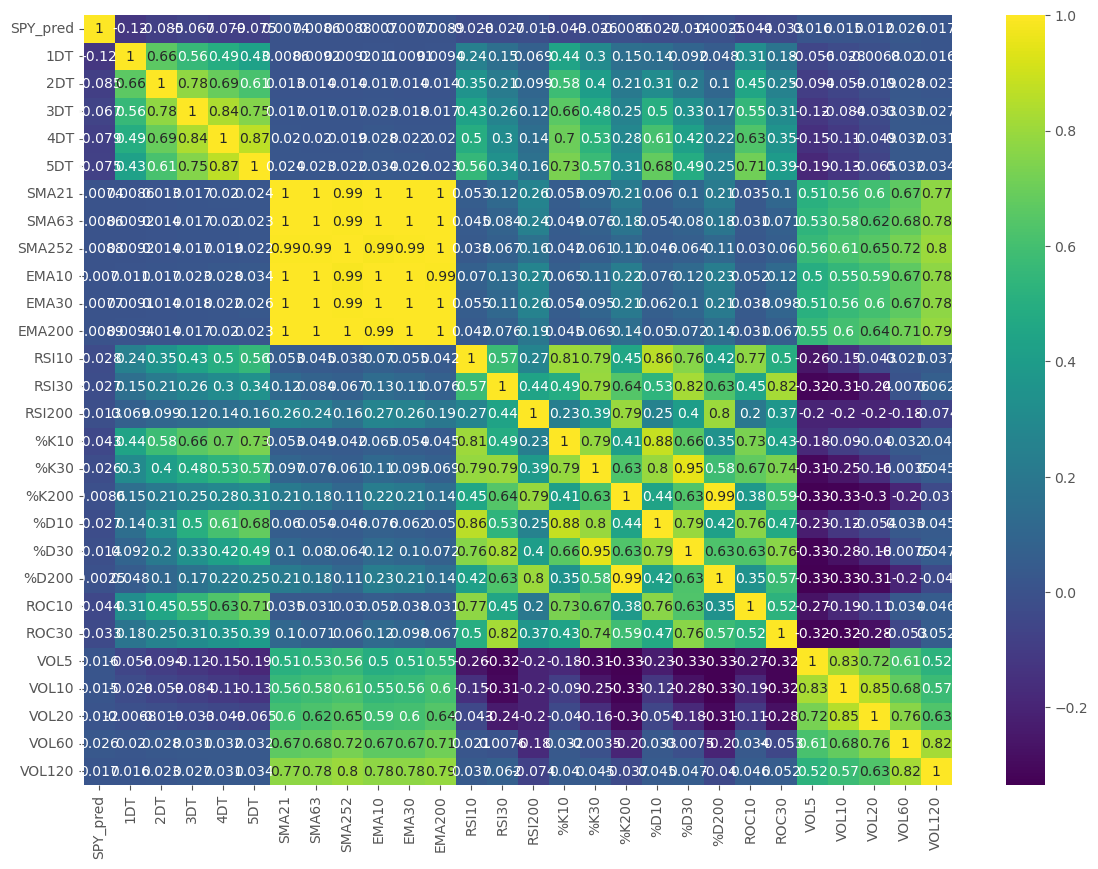

In [35]:

plt.figure(figsize=(14, 10))  # ← adjust size here

(
    sns
    .heatmap(correlation,
             cmap = "viridis",
             annot = True)
)

plt.show()

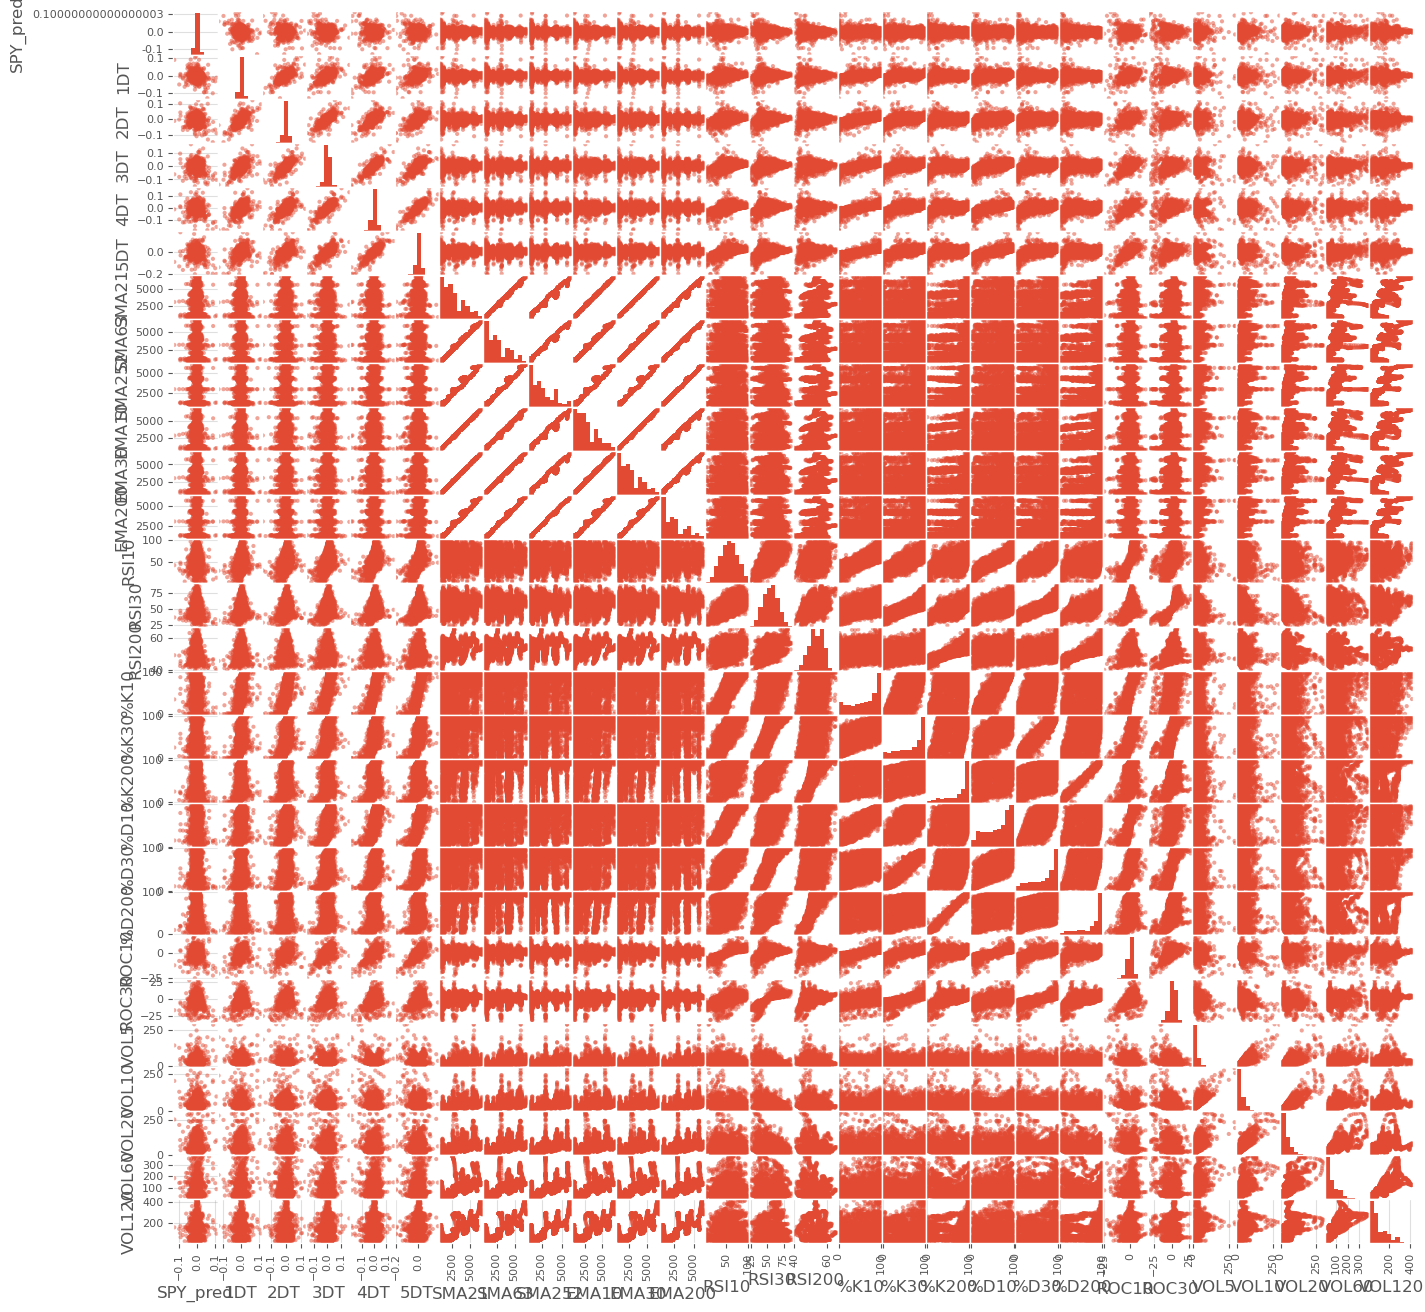

In [36]:
scatter_matrix(data,
               figsize = [16,16]
              )

plt.show()

In [37]:
from sklearn.metrics import mean_squared_error


class SupervisedLearning:

    def __init__(self):
        """Initialize all regression models."""
        self.models = []
        self._init_models()

    def _init_models(self):
        # Linear Models
        self.models.append(("LR", LinearRegression()))
        self.models.append(("LASSO", Lasso()))
        self.models.append(("Elastic Net Penalty", ElasticNet()))

        # Tree-Based
        self.models.append(("Decision Tree", DecisionTreeRegressor()))

        # Bagging
        self.models.append(("Random Forest", RandomForestRegressor()))
        self.models.append(("Extra Trees", ExtraTreesRegressor()))

        # Boosting
        self.models.append(("Gradient Boosting", GradientBoostingRegressor()))
        self.models.append(("Adaptive Boosting", AdaBoostRegressor()))

        # Kernel / Distance-based
        self.models.append(("Support Vector Machine", SVR()))
        self.models.append(("K-Nearest Neighbors", KNeighborsRegressor()))

    def get_model_by_name(self, name):
        for n, model in self.models:
            if name == n:
                return model
            
        print("Warning! no name found")
        return self.models[0];


    def sequential_split(self, X: pd.DataFrame, Y: pd.Series, train_frac=0.8):
        if len(X) != len(Y):
            raise ValueError("X and Y must be equal length")

        if train_frac <= 0 or train_frac >= 1:
            raise ValueError("Train fraction must be between 0 and 1")

        train_size = int(len(X) * train_frac)

        X_train, X_test = X[0:train_size], X[train_size:]
        Y_train, Y_test = Y[0:train_size], Y[train_size:]

        print(f"Sequential Split: {len(X_train)} train / {len(X_test)} test samples")
        return X_train, X_test, Y_train, Y_test
    

    def run_all_models(self, X_train, Y_train, X_test, Y_test, 
                       num_folds=10, seed=42, metric="neg_mean_squared_error"):
        names, kfold_results, train_results, test_results = [], [], [], []

        for name, model in self.models:
            names.append(name)

            kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

            # Cross-validation (negative MSE -> convert to positive)
            cv_results = -1 * cross_val_score(model, X_train, Y_train, cv=kfold, scoring=metric)
            kfold_results.append(cv_results)

            # Fit model
            res = model.fit(X_train, Y_train)

            # Compute train/test MSE
            train_mse = mean_squared_error(Y_train, res.predict(X_train))
            test_mse = mean_squared_error(Y_test, res.predict(X_test))

            train_results.append(train_mse)
            test_results.append(test_mse)

            # Display progress
            print(f"{name}: CV_Mean={cv_results.mean():.4f}, CV_Std={cv_results.std():.4f}, Train_MSE={train_mse:.4f}, Test_MSE={test_mse:.4f}")

        df_for_comparison = pd.DataFrame({
            "Algorithms": names * 2,
            "Data": ["Training Set"] * len(names) + ["Testing Set"] * len(names),
            "Performance": train_results + test_results
        })

        return {
            "names": names,
            "kfold_results": kfold_results,
            "train_results": train_results,
            "test_results": test_results,
            "comparison_df": df_for_comparison
        }

    def plot_performance(self, df_for_comparison: pd.DataFrame):
        performance_comparison =\
        (
            ggplot(df_for_comparison,
                aes(x = "Algorithms",
                    y = "Performance",
                    fill = "Data"
                    )
                )
            + geom_bar(stat = "identity",
                    position = "dodge",
                    width = 0.5)
            + labs(title = "Comparing the Performance of Machine Learning Algorithms on the Training vs. Testing Set",
                y = "Mean Squared Error (MSE)",
                x = "Name of ML Algorithms",
                caption = "Source: Federal Reserve Bank & Yahoo Finance")
            + theme(legend_position = "top")
            + ggsize(1000, 500)
        )

        performance_comparison.show()


In [38]:
SL =\
(
    SupervisedLearning()
)

In [39]:
X_train, X_test, Y_train, Y_test =\
(
    SL
    .sequential_split(X,Y,train_frac=0.75)
    
)

Sequential Split: 3402 train / 1134 test samples


In [40]:
seed = 2025
num_folds = 10

metric = "neg_mean_squared_error"

In [41]:
results =\
(
    SL
    .run_all_models(
        X_train = X_train,
        Y_train = Y_train,
        X_test = X_test,
        Y_test = Y_test,
        num_folds = num_folds,
        seed = seed,
        metric = metric
    )
)

LR: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
LASSO: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
Elastic Net Penalty: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
Decision Tree: CV_Mean=0.0004, CV_Std=0.0001, Train_MSE=0.0000, Test_MSE=0.0005
Random Forest: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0000, Test_MSE=0.0002
Extra Trees: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0000, Test_MSE=0.0002
Gradient Boosting: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0002
Adaptive Boosting: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0001
Support Vector Machine: CV_Mean=0.0003, CV_Std=0.0001, Train_MSE=0.0002, Test_MSE=0.0002
K-Nearest Neighbors: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0001


In [42]:
results['comparison_df']

,Algorithms,Data,Performance
0,LR,Training Set,1.687087e-04
1,LASSO,Training Set,1.755299e-04
2,Elastic Net Penalty,Training Set,1.755299e-04
3,Decision Tree,Training Set,0.000000e+00
4,Random Forest,Training Set,2.748308e-05
5,Extra Trees,Training Set,6.782081e-35
6,Gradient Boosting,Training Set,1.020376e-04
7,Adaptive Boosting,Training Set,1.439822e-04
8,Support Vector Machine,Training Set,2.217278e-04
9,K-Nearest Neighbors,Training Set,1.387184e-04


In [43]:
from lets_plot import *
LetsPlot.setup_html()

In [44]:
(
    SL
    .plot_performance(results['comparison_df'])
)

In [45]:
model =\
(
    SL.get_model_by_name("K-Nearest Neighbors")
)

model

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [46]:
return_df

Ticker,Close
Date,
2006-11-01,1367.810059
2006-11-02,1367.339966
2006-11-03,1364.300049
2006-11-06,1379.780029
2006-11-07,1382.839966
...,...
2025-11-06,6720.319824
2025-11-07,6728.799805
2025-11-10,6832.430176


In [47]:
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [48]:
testing_df =\
(
    spy
    ['Close']
    .rename(columns={'^GSPC': "actual_close"})
)

testing_df

Ticker,actual_close
Date,
2006-11-01,1367.810059
2006-11-02,1367.339966
2006-11-03,1364.300049
2006-11-06,1379.780029
2006-11-07,1382.839966
...,...
2025-11-06,6720.319824
2025-11-07,6728.799805
2025-11-10,6832.430176


In [49]:
testing_df.loc[X_test.index, "pred_return"] = y_pred
testing_df

Ticker,actual_close,pred_return
Date,,
2006-11-01,1367.810059,NaN
2006-11-02,1367.339966,NaN
2006-11-03,1364.300049,NaN
2006-11-06,1379.780029,NaN
2006-11-07,1382.839966,NaN
...,...,...
2025-11-06,6720.319824,-0.000202
2025-11-07,6728.799805,-0.000202
2025-11-10,6832.430176,-0.000202


In [50]:
testing_df["pred_close"] =\
(
    testing_df["actual_close"] 
    * np.exp(testing_df["pred_return"])
)

In [51]:
testing_df =\
(
    testing_df
    .dropna()
)

testing_df

Ticker,actual_close,pred_return,pred_close
Date,,,
2021-05-10,4188.430176,-0.000202,4187.584692
2021-05-11,4152.100098,-0.000202,4151.261947
2021-05-12,4063.040039,0.001687,4069.900700
2021-05-13,4112.500000,-0.000202,4111.669844
2021-05-14,4173.850098,-0.000202,4173.007557
...,...,...,...
2025-11-05,6796.290039,-0.000202,6794.918128
2025-11-06,6720.319824,-0.000202,6718.963249
2025-11-07,6728.799805,-0.000202,6727.441517


In [52]:
(
    testing_df 
)

Ticker,actual_close,pred_return,pred_close
Date,,,
2021-05-10,4188.430176,-0.000202,4187.584692
2021-05-11,4152.100098,-0.000202,4151.261947
2021-05-12,4063.040039,0.001687,4069.900700
2021-05-13,4112.500000,-0.000202,4111.669844
2021-05-14,4173.850098,-0.000202,4173.007557
...,...,...,...
2025-11-05,6796.290039,-0.000202,6794.918128
2025-11-06,6720.319824,-0.000202,6718.963249
2025-11-07,6728.799805,-0.000202,6727.441517


In [53]:
def generate_signal_simple(df: pd.DataFrame):
    df = df.copy()

    df['signal'] = (df['pred_return'] > 0).astype(int)

    df['positions'] =\
    (
        df['signal']
        .ffill()
        .shift(1)
    )

    return df

In [54]:
testing_df =\
(
    generate_signal_simple(testing_df)
    .dropna()
)
testing_df

Ticker,actual_close,pred_return,pred_close,signal,positions
Date,,,,,
2021-05-11,4152.100098,-0.000202,4151.261947,0,0.0
2021-05-12,4063.040039,0.001687,4069.900700,1,0.0
2021-05-13,4112.500000,-0.000202,4111.669844,0,1.0
2021-05-14,4173.850098,-0.000202,4173.007557,0,0.0
2021-05-17,4163.290039,-0.000202,4162.449630,0,0.0
...,...,...,...,...,...
2025-11-05,6796.290039,-0.000202,6794.918128,0,0.0
2025-11-06,6720.319824,-0.000202,6718.963249,0,0.0
2025-11-07,6728.799805,-0.000202,6727.441517,0,0.0


In [55]:
def compute_cumulative_returns(df, 
                       position_column = 'positions',
                       price_column = 'Close'):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df[price_column]
            /
            df[price_column].shift(1)
            )
    )

    df['strategy_returns'] =\
    (
        df[position_column].shift(1)
        *
        df['passive_returns']
    )

    df['cum_log_returns'] =\
    (
        df['strategy_returns']
        .cumsum()
    )

    df['cumulative_returns_strategy'] =\
    (
        np.exp(
            df['cum_log_returns']
        )
    )

    df['cumulative_max_strategy'] =\
    (
        df['cumulative_returns_strategy']
        .cummax()
    )

    df['cumulative_returns_passive'] =\
    (
        np.exp(
            df['passive_returns']
            .cumsum()
        )
    )
    return df

<Axes: xlabel='Date'>

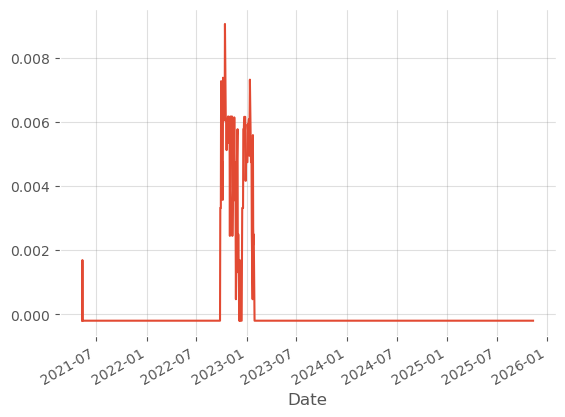

In [56]:
(
    testing_df['pred_return']
).plot()

In [57]:
testing_df =\
(
    compute_cumulative_returns(
        df = testing_df,
        position_column='positions',
        price_column = 'actual_close'
    )
)
testing_df

Ticker,actual_close,pred_return,pred_close,signal,positions,passive_returns,strategy_returns,cum_log_returns,cumulative_returns_strategy,cumulative_max_strategy,cumulative_returns_passive
Date,,,,,,,,,,,
2021-05-11,4152.100098,-0.000202,4151.261947,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-12,4063.040039,0.001687,4069.900700,1,0.0,-0.021683,-0.000000,0.000000,1.000000,1.000000,0.978551
2021-05-13,4112.500000,-0.000202,4111.669844,0,1.0,0.012100,0.000000,0.000000,1.000000,1.000000,0.990463
2021-05-14,4173.850098,-0.000202,4173.007557,0,0.0,0.014808,0.014808,0.014808,1.014918,1.014918,1.005238
2021-05-17,4163.290039,-0.000202,4162.449630,0,0.0,-0.002533,-0.000000,0.014808,1.014918,1.014918,1.002695
...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05,6796.290039,-0.000202,6794.918128,0,0.0,0.003647,0.000000,0.122043,1.129803,1.129803,1.636832
2025-11-06,6720.319824,-0.000202,6718.963249,0,0.0,-0.011241,-0.000000,0.122043,1.129803,1.129803,1.618535
2025-11-07,6728.799805,-0.000202,6727.441517,0,0.0,0.001261,0.000000,0.122043,1.129803,1.129803,1.620577


<Axes: xlabel='Date'>

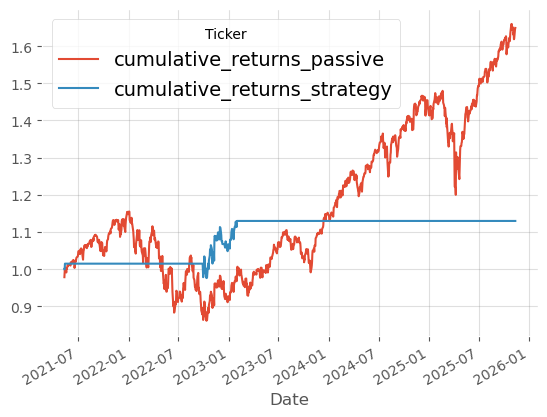

In [58]:
(
    testing_df
    [['cumulative_returns_passive', 'cumulative_returns_strategy']]
).plot()

In [59]:
print(f"Cumulative Returns (Passive): {testing_df['cumulative_returns_passive'].iloc[-1]:.2f}")
print(f"Cumulative Returns (Strategy): {testing_df['cumulative_returns_strategy'].iloc[-1]:.2f}")

Cumulative Returns (Passive): 1.65
Cumulative Returns (Strategy): 1.13
